dt: 36.0, computed dt: 163.3986928104575 critical dt: 16339869281.04575
Completed: 0.0 %
Completed: 10.0 %
Completed: 20.0 %
Completed: 30.0 %
Completed: 40.0 %
Completed: 50.0 %
Completed: 60.0 %
Completed: 70.0 %
Completed: 80.0 %
Completed: 90.0 %
Completed: 100.0 %
Conduction:  1.0
Total simulation time: 360036.0 hours


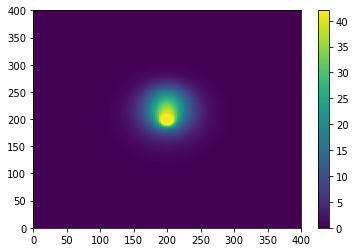

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

# box size, m
w = h = 4.
# intervals in x-, y- directions, m
dx = dy = 0.01
# Thermal diffusivity, m2.s-1
alpha = 1.53e-7
# Porosity
n = 0.4
# Viscosity kg/m
nu = 1.00E-03 
# Permeability m2
k = 4e-11
# Thermal expansion 
beta = 8.80E-05
# Cf
cf = 4290
# rhow
rhow = 980

# Set conduction to 0 to disable
conduction = 1.

# Temperature of the cable
Tcool, Thot = 0, 42

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 0.1, 2, 2

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * alpha * (dx2 + dy2))

dt = 0.01 * 3600
print("dt: {}, computed dt: {} critical dt: {}".format(dt, dx2 * dy2 / (2 * alpha * (dx2 + dy2)), 1/(2 * alpha * (dx2 + dy2))))


u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

uu = []


# Initial conditions
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space, upwind solution for convection
    # Convection velocity term:
    # The velocity corresponds to differential density, since we are measuring the differnetial temp,
    # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + \
     + conduction * alpha * dt * ((u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
          (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2) + \
    dt * (1/(n*nu)*k*9.81*rhow)*(beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)

    for i in range(nx):
        for j in range(ny):
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            if p2 < r2:
                u[i,j] = Thot

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 10001
npercent = int(nsteps/100)
for m in range(nsteps):
    if m % (10*npercent) == 0:
        print("Completed: {} %".format(m/npercent))
    u0, u = do_timestep(u0, u)
    uu.append(u.copy())

print("Conduction: ", conduction)
print("Total simulation time: {} hours".format(dt * nsteps))

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
plt.colorbar()    

In [ ]:
def step(i):
    j = int(nsteps/100*i)
    pcm.set_array(np.flipud(uu[j]).ravel())
    plt.draw()

anim = FuncAnimation(fig, step, interval=50)
HTML(anim.to_html5_video())

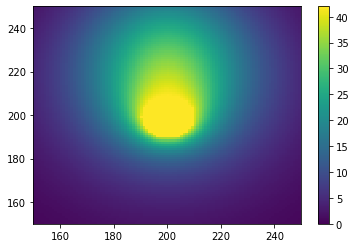

In [19]:

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
plt.ylim(150,250)
plt.xlim(150,250)
plt.colorbar()    

In [21]:
sum = 0
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 > r2:
            sum += u[i,j]


In [24]:
print(sum*rhow*cf/100)

6223139541.375158
